GMDL open set recognition project

Yuval Zirler 318644010

Yehuda Shargal 318621968

# Introduction and explanation of our project

Our first thought when encountering the open set recognition problem was that, since the number of classes was relatively small, we might achieve good results if we use a network of 10 convolution networks-one for each digit-and determine for each image the probability of it representing each digit, and then make a decision according to said probabilities. We achieved decent results and attempted many different ideas to improve the accuracy-some of them worked, some of them did not.
In general the clasification rule, at first, was as follows: for each image, get the probabilities for it being a digit from each convolution network. If just one of them is positive, it is that digit, otherwise it is not a digit and therefore OOD. We have then made the following observations:

1.   There were only a few images (if any at all) which were positive for more than one digit.
2.   There were much more false negatives (digits classified as OOD) than false positives (OOD classified as digits).

These observations made us realize that we should alter that rule a bit. We tried to implement a rule based on the difference between the highest and second highest probabilities, but it only decreased the accuracy. We assume that some of the OOD images were negative for all digits but much less negative for one digit, such as a picture containing two lines at an angle which may have looked similar to a seven but not enough to be positive. However, making the threshold more lax by decreasing it helped, as shown by this graph for different thresholds with the same training weights:

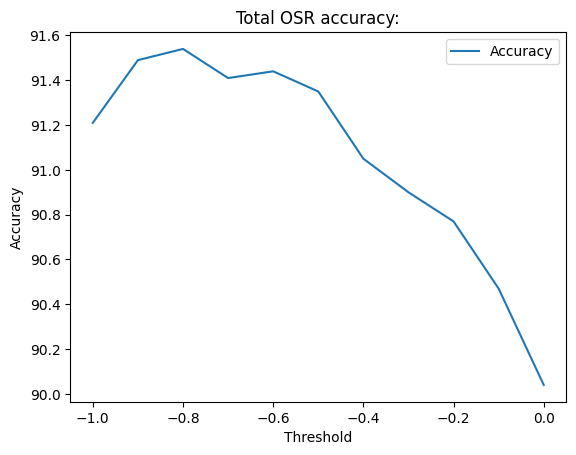

In addition, we also had to make a lot of decisions about the convolution networks themselves as well as data augmentations. We discovered that blurring helped but rotating only caused confusion between digits. We reached ideal performance with two convolution networks with large kernels and three relatively small fully connected layers per digit-the large kernels helped catch relevant features but when enlarged too much they caused consistent missclassifications of eights as zeros, maybe bacause they were large enough to contain each circle in its entirety and mistakenly believed the eight is just two zeros. If the fully connected layers were too large, the train error was small but the validation error was large, which is a clear sign of overfitting. We have also tried using dropout, without any significant improvement.

The biggest advantage of this model is that it is simple and easy to adjust for other distributions as long as they have a small number of classes. For example, one could adjust the model to identify animals from a small group, or even letters of the english alphabet, but it would not be practical for a distribution with hundreds of classes. We also believe that the model will work well on other models and not just CIFAR10, especially if the pictures in that dataset look very different than numbers.


# Imports and utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import MNIST, CIFAR10
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# OSR Dataset template
class CombinedDataset(Dataset):
  def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
    self.mnist = mnist
    self.ood = ood
    # transforms could be defined either here or when you init each dataset.
    self.transform_mnist = transform_mnist
    self.transform_ood = transform_ood

  def __len__(self):
    # combined length of MNIST and OOD
    return len(self.mnist) + len(self.ood)

  def __getitem__(self, idx):
    if idx < len(self.mnist):
      # if index is within the range of MNIST, return MNIST data and label
      data, label = self.mnist[idx]
      if self.transform_mnist:
        data = self.transform_mnist(data)
      return data, label
    else:
      # if index is beyond the range of MNIST, return OOD data and 10 as label
      data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
      if self.transform_ood:
        data = self.transform_ood(data)
      return data, 10  # OOD label is always 10

# Datasets and dataloaders

### Defining the databases

In [3]:
N = 10000
batch_size = 128
n = 2000
generator = torch.manual_seed(0)
np.random.seed(0)

augmentation = transforms.Compose([T.ToTensor(),
                      T.Normalize((0.5,), (0.5,)),
                      T.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 1))])
mnist_transform = transforms.Compose([T.ToTensor(),
                      T.Normalize((0.5,), (0.5,))])
# Normalization based on expected values found online
cifar_transform = transforms.Compose([T.ToTensor(),T.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
                                 T.Grayscale(num_output_channels=1),
                                 T.Resize(28)])

augmentedTrainset = torchvision.datasets.MNIST(root="./data/", train=True, download=True, transform=augmentation)
mnistTrain = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=mnist_transform)
mnist= torchvision.datasets.MNIST(root="./data/", train=False, download=True, transform=mnist_transform)
ood = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

split = np.random.choice(np.arange(len(mnistTrain)), N)
train_split = split[:8000]
valid_split = split[8000:]

indexes = np.random.choice(len(ood), n)
cifar_only_dataset = torch.utils.data.Subset(ood, indexes)
combined_ds = CombinedDataset(mnist, cifar_only_dataset)


100%|██████████| 9912422/9912422 [00:00<00:00, 60911705.90it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35224104.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25854669.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3646034.21it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170498071/170498071 [00:02<00:00, 81678946.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


### Defining the dataloaders

In [4]:
augmentedTrain = torch.utils.data.Subset(augmentedTrainset, train_split)
augmentedValid = torch.utils.data.Subset(augmentedTrainset, valid_split)
train_loader = torch.utils.data.DataLoader(augmentedTrain, batch_size=batch_size, num_workers=2)
valid_loader = torch.utils.data.DataLoader(augmentedValid, batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=False, num_workers=2)

batch_size = 1024
data_loader = DataLoader(combined_ds, batch_size=batch_size, shuffle=True)
OOD_test_loader = torch.utils.data.DataLoader(combined_ds, batch_size=batch_size,shuffle=True, num_workers=2)

# The model


### The single CNN for a single digit

In [5]:
class Binary_CNN(nn.Module):
  def __init__(self):
    super(Binary_CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, 7, padding='same')
    self.conv2 = nn.Conv2d(64, 32, 5, padding='same')
    self.fc1 = nn.Linear(32, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, (2, 2))
    x = self.conv2(x)
    x = F.relu(x)
    x = F.adaptive_avg_pool2d(x, 1)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

### Networks

In [6]:
class Binary_CNN_Network(nn.Module):
  def __init__(self, cnnList, OSR_mode=True):
    super(Binary_CNN_Network, self).__init__()
    self.cnnList = cnnList
    self.OSR_mode = OSR_mode

  def _processOOD(self, results):
    preds = []
    # We make an array pred that contains the probabilities for it being a digit
    for i in range(results[0].shape[0]):
      probs = []
      pred = [0 for i in range(10)]
      for digit in range(10):
        prob = results[digit][i][1].item()
        if prob > -0.8:
          probs.append(prob)
          pred[digit] = 1
        else:
          probs.append(0)
      if self.OSR_mode:
        if (sum(pred) == 1):
          pred.append(0)
        else:
          pred.append(1.1)
      preds.append(pred)

    preds_result = torch.tensor(preds).to(device)
    return preds_result

  def forward(self, x):
    results = []
    with torch.no_grad():
      for model in self.cnnList:
        results.append(model(x))
    return self._processOOD(results)


### Array of networks

In [7]:
num_epochs = 10
cnns = []
cnns_params = []

for i in range(10):
  model_i = Binary_CNN().to(device)
  cnns.append(model_i)
  cnns_params.append([nn.CrossEntropyLoss(), optim.Adam(model_i.parameters(), lr=0.01)])

# Training

### Binary CNN Training

In [8]:
def binary_train_epoch(model, dataloader, criterion, optimizer, chosen_label):
  model.train()
  running_loss = 0
  curr = 0

  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    probs, preds = torch.max(outputs, 1)
    # Turning the vector into a boolean vector
    for j in range(labels.shape[0]):
      labels[j] = 1 if labels[j] == chosen_label else 0
      preds[j] = 1 if preds[j] == chosen_label else 0

    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    curr += torch.sum(preds == labels.data).cpu()

  loss = running_loss / len(train_split)
  accuracy = ((curr.double() / len(train_split)) * 100)
  return loss, accuracy

In [9]:
def binary_val_epoch(model, dataloader, criterion, chosen_label):
  model.eval()
  running_loss = 0
  curr = 0

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      probs, preds = torch.max(outputs, 1)

      for j in range(labels.shape[0]):
        labels[j] = 1 if labels[j] == chosen_label else 0
        preds[j] = 1 if preds[j] == chosen_label else 0
      loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      curr += torch.sum(preds == labels.data).cpu()

  loss = running_loss / len(valid_split)
  accuracy = ((curr.double() / len(valid_split)) * 100)

  return loss, accuracy

###Training the network

In [10]:
trainLosses = [[0 for i in range(num_epochs)] for j in range(10)]
trainAccuracies = [[0 for i in range(num_epochs)] for j in range(10)]
validLosses = [[0 for i in range(num_epochs)] for j in range(10)]
validAccuracies = [[0 for i in range(num_epochs)] for j in range(10)]
for i in range(10):
  optimalAccuracy = 0
  path = "./"+str(i)+"_weights.pth"
  for epoch in range(num_epochs):
    trainLoss, trainAccuracy = binary_train_epoch(cnns[i], train_loader, cnns_params[i][0], cnns_params[i][1], i)
    valLoss, valAccuracy = binary_val_epoch(cnns[i], valid_loader, cnns_params[i][0], i)
    trainLosses[i][epoch] = trainLoss
    trainAccuracies[i][epoch] = trainAccuracy
    validLosses[i][epoch] = valLoss
    validAccuracies[i][epoch] = valAccuracy
    if valAccuracy > optimalAccuracy:
      torch.save(copy.deepcopy(cnns[i].state_dict()), path)

### Loss and accuracy graphs

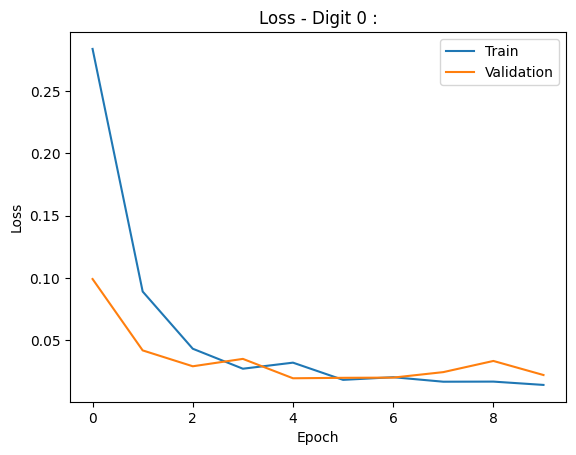

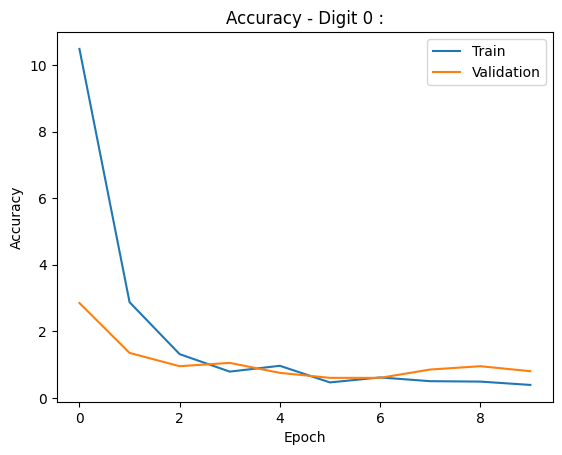

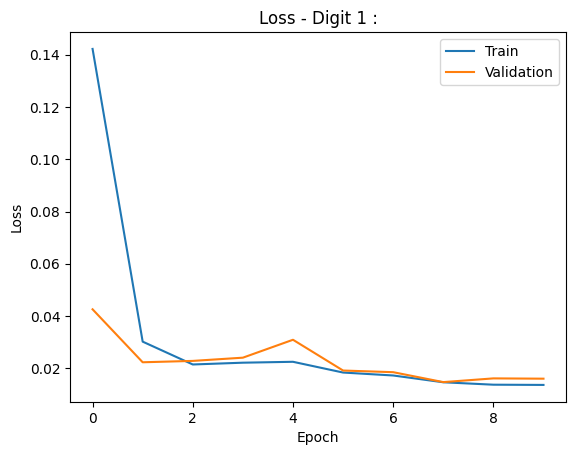

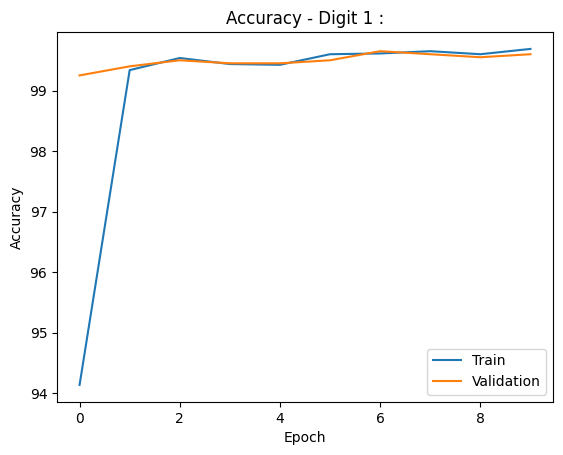

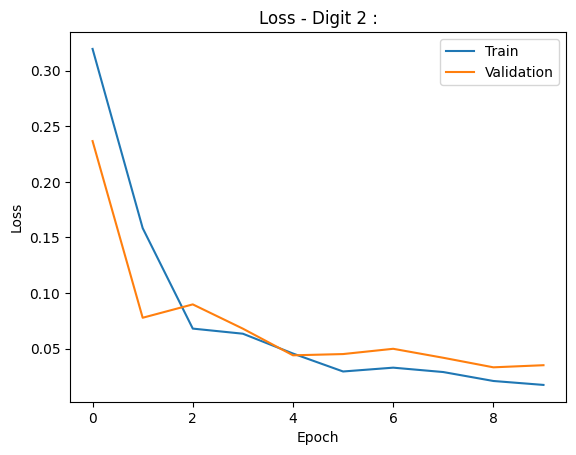

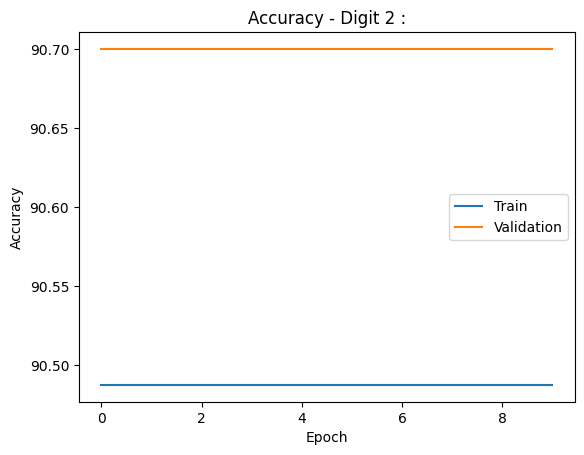

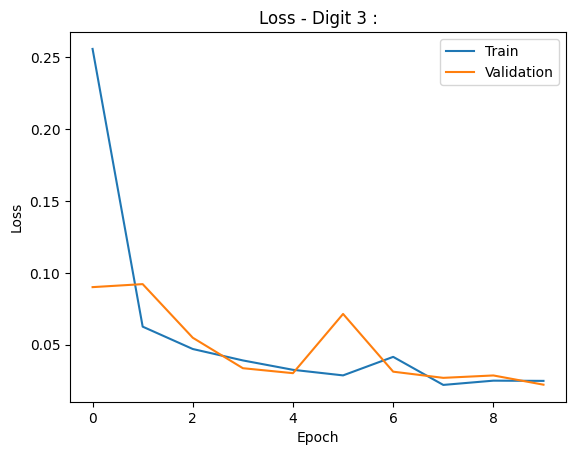

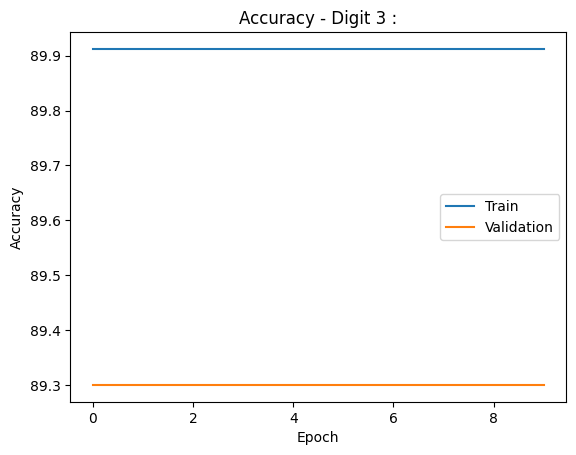

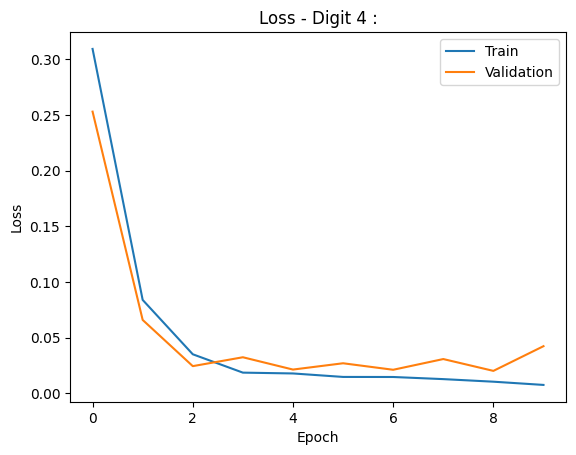

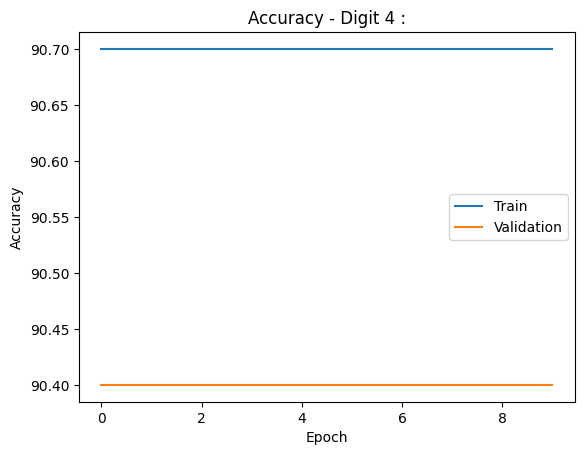

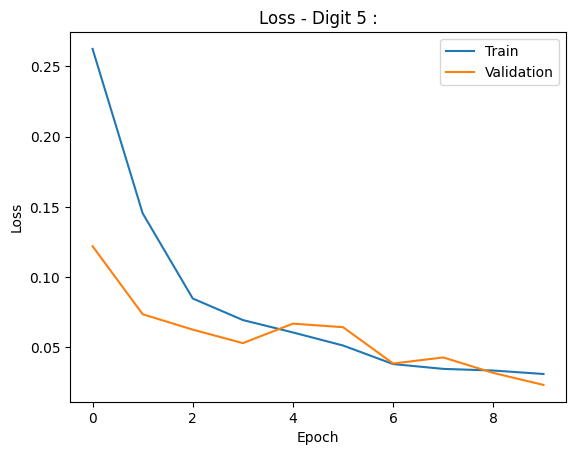

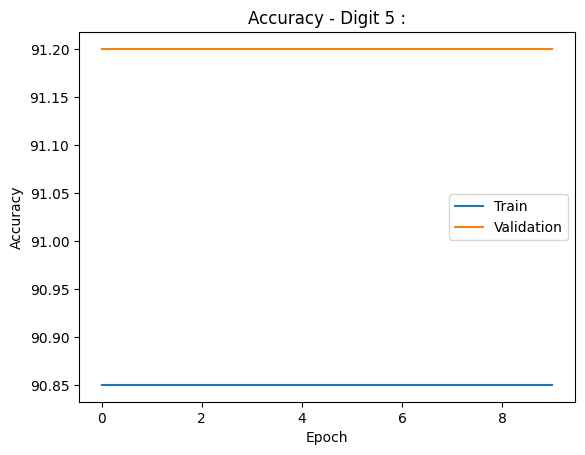

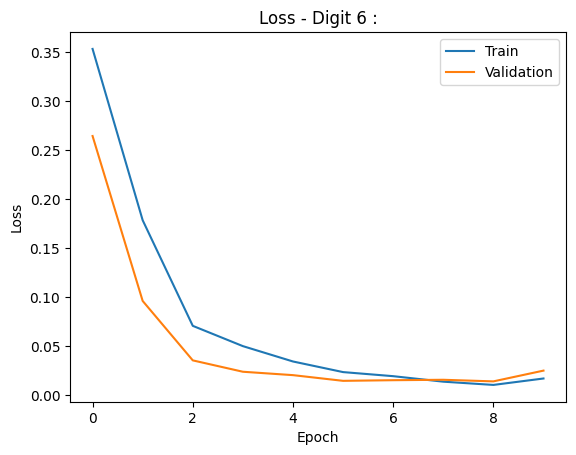

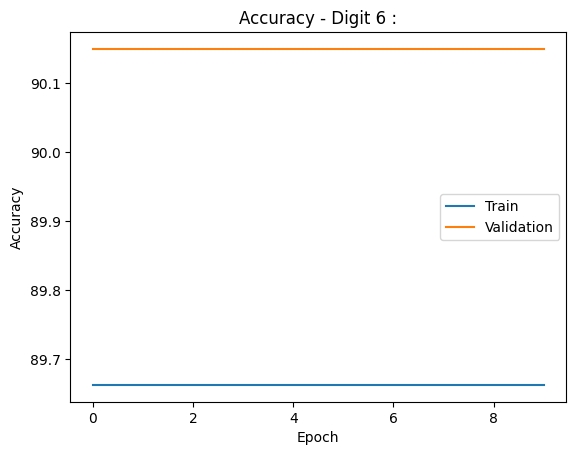

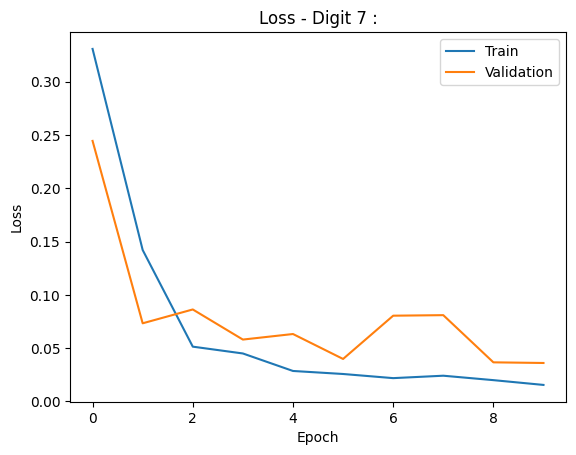

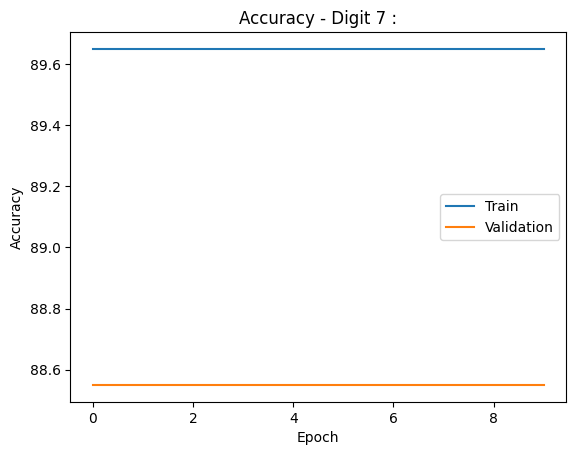

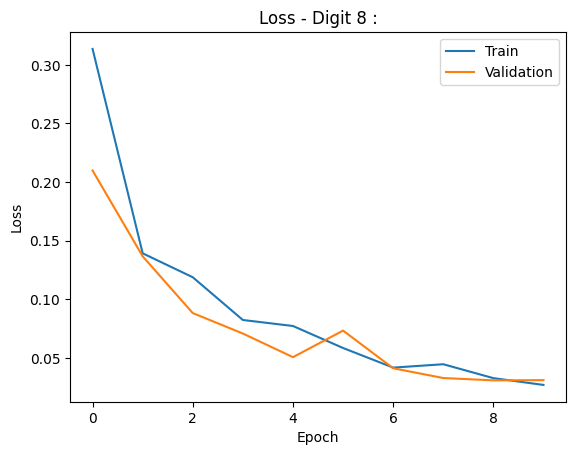

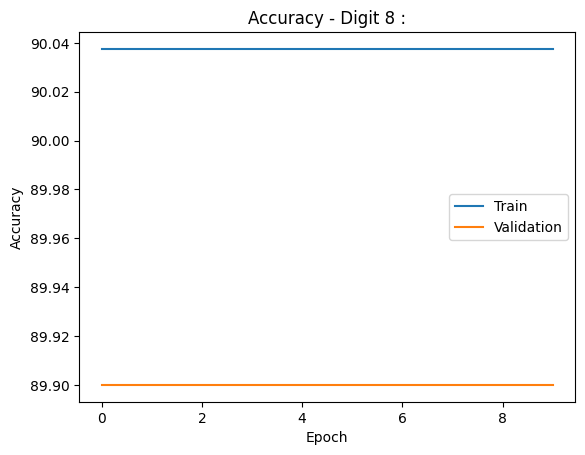

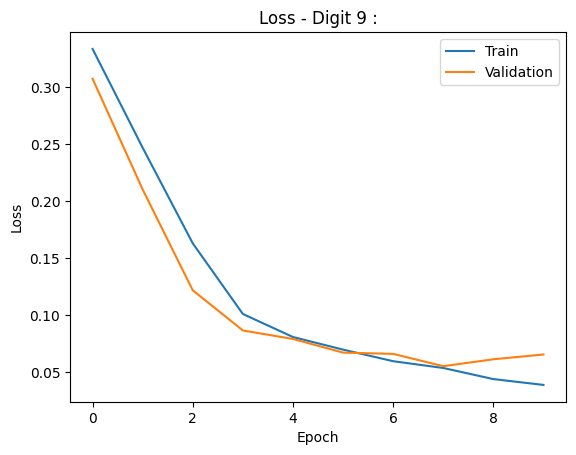

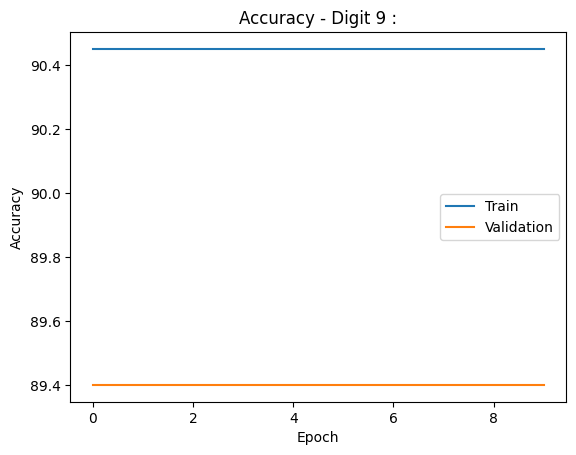

In [11]:
totalTrainLoss = [0 for i in range(num_epochs)]
totalValidLoss = [0 for i in range(num_epochs)]
totalTrainAcc = [0 for i in range(num_epochs)]
totalValidAcc = [0 for i in range(num_epochs)]
x_axis = list(range(num_epochs))

for i in range(10):
  for epoch in range(num_epochs):
    totalTrainLoss[epoch] += trainLosses[i][epoch]
    totalValidLoss[epoch] += validLosses[i][epoch]
    totalTrainAcc[epoch] += trainAccuracies[i][epoch]
    totalValidAcc[epoch] += validAccuracies[i][epoch]

  plt.title(f"Loss - Digit {i} :")
  plt.plot(x_axis, trainLosses[i], label="Train")
  plt.plot(x_axis, validLosses[i], label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.title(f"Accuracy - Digit {i} :")
  plt.plot(x_axis, trainAccuracies[i], label="Train")
  plt.plot(x_axis, validAccuracies[i], label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

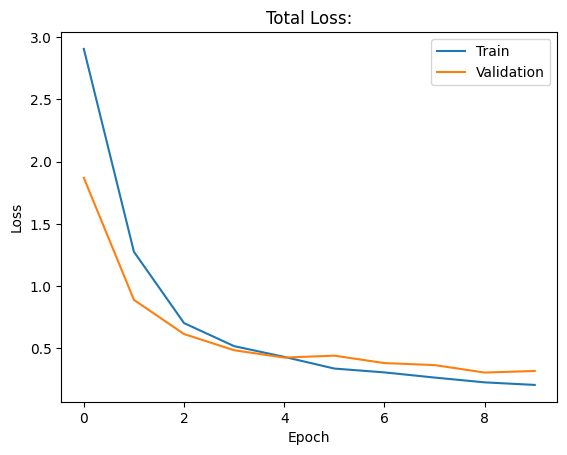

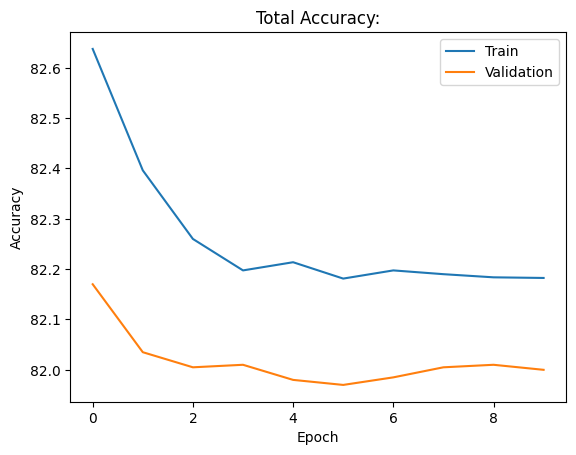

In [12]:
plt.title(f"Total Loss:")
plt.plot(x_axis, totalTrainLoss, label="Train")
plt.plot(x_axis, totalValidLoss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title(f"Total Accuracy:")
plt.plot(x_axis, [x/10 for x in totalTrainAcc], label="Train")
plt.plot(x_axis, [x/10 for x in totalValidAcc], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## Load the trained weights

In [13]:
for i in range(10):
  path = "./"+str(i)+"_weights.pth"
  cnns[i].load_state_dict(torch.load(path))

# Evaluation

### Baseline-digits

Baseline accuracy is 94.33 %


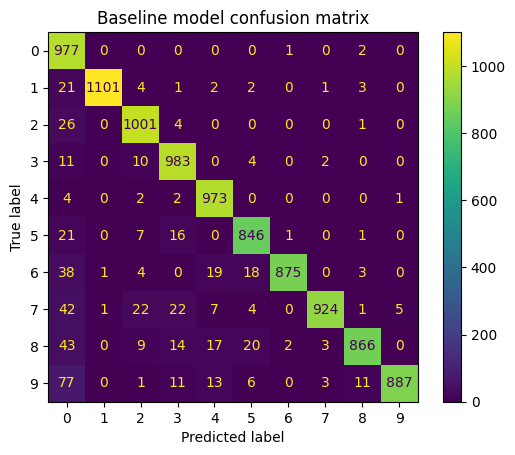

In [14]:
Baseline_model = Binary_CNN_Network(cnns, OSR_mode=False)
trueLabels = []
predictedLabels = []
def eval_model(model, dataloader):
  count, total = 0, 0
  model.eval()
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      images, preds = torch.max(outputs, 1)
      pred = torch.eq(labels, preds).cpu()
      count += torch.sum(pred).item()
      total += len(labels)
      trueLabels.extend(labels.tolist())
      predictedLabels.extend(preds.tolist())
  print("Baseline accuracy is", (count/total)*100, "%")

eval_model(Baseline_model, test_loader)
baseline_labels = [i for i in range(10)]
matrix = confusion_matrix(trueLabels, predictedLabels, labels=baseline_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=baseline_labels)
disp.plot()
plt.title("Baseline model confusion matrix")
plt.show()

### OSR results

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Baseline accuracy is 91.54166666666667 %


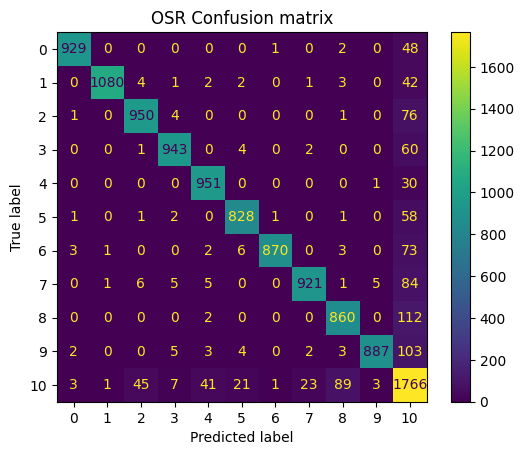

In [15]:
OSR_model = Binary_CNN_Network(cnns)
trueLabels = []
predictedLabels = []

eval_model(OSR_model, OOD_test_loader)

clf_labels = [i for i in range(11)]
cm = confusion_matrix(trueLabels, predictedLabels, labels=clf_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_labels)
disp.plot()
plt.title("OSR Confusion matrix")
plt.show()


MNIST/OOD accuracy is  92.33333333333333 %


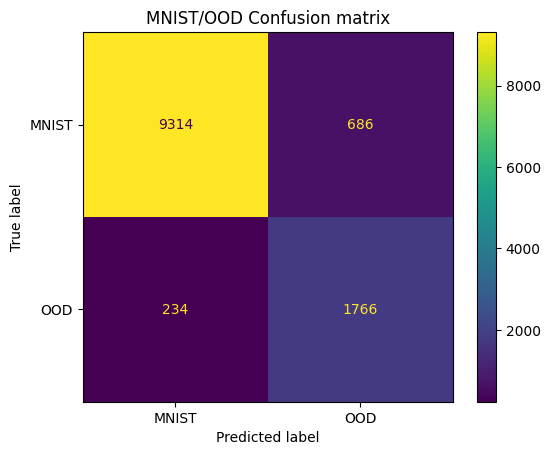

In [16]:
def MNIST_OOD_Converter(trueLabels, predictedLabels):
  for i in range(len(trueLabels)):
    if (trueLabels[i] < 10):
      trueLabels[i] = 0
    else:
      trueLabels[i] = 1
  for i in range(len(predictedLabels)):
    if (predictedLabels[i] < 10):
      predictedLabels[i] = 0
    else:
      predictedLabels[i] = 1
  count = 0
  for i in range(len(trueLabels)):
    if (trueLabels[i] == predictedLabels[i]):
      count += 1
  print("MNIST/OOD accuracy is ", (count/len(trueLabels))*100, "%")
  return trueLabels, predictedLabels
binaryLabels, binaryPreds = MNIST_OOD_Converter(trueLabels, predictedLabels)
cm = confusion_matrix(trueLabels, predictedLabels, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['MNIST','OOD'])
disp.plot()
plt.title("MNIST/OOD Confusion matrix")
plt.show()

### Accuracy calculations

In [17]:
def eval_model2(model, data_loader, device):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)

            ### Modify output if needed ###

            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here.

            # Assuming the model returns an (N_batch, 11) size output
            probas, y_pred = torch.max(outputs, 1)

	    # Assuming the model retuns the predicted label (N_batch, )
	    # y_pred = outputs

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total

In [18]:
acc_mnist, acc_ood, acc_total = eval_model2(OSR_model, OOD_test_loader, device)
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

MNIST Accuracy: 92.19%
OOD Accuracy: 88.30%
Total Accuracy: 91.54%
